In [342]:
#import libraries
import glob
import cv2 as cv
import numpy as np
import random
from PIL import Image, ImageFilter
import pandas as pd
import math
from skimage import io
import matplotlib.pyplot as plt
from scipy import fftpack
from skimage.restoration import denoise_wavelet, cycle_spin
from skimage.util import random_noise

def main(function_filter,filter_class): #function with the name of the filter and the class 
    #(0= Mean/Median/Combined,1=Low Pass and other is Wavelet).
    Image=[]
    Noise=[]
    ratio = 0.2 #ratio for the combined filter.
    Denoise=[]
    Error_RMSE=[]
    Error_NRMSE=[]
    Error_SNR=[]
    Error_PSNR=[]
    for i in range(1,11):
        if(i<10):#Take the path of the images
            path=glob.glob("Img/Sample00"+str(i)+"/img00"+str(i)+"-001.png")
        else:
            path=glob.glob("Img/Sample0"+str(i)+"/img0"+str(i)+"-001.png")
        for img in path:
            n = cv.imread(img,0)
            Image.append(n)
            if(filter_class==0):#We add the noise and then denoise the image and remove the border
                noise_image=skimage.util.random_noise(n, mode='gaussian', mean=0.3,seed=None, clip=True)
                noise_image=skimage.util.random_noise(n, mode='pepper', amount=0.1,seed=None, clip=True)
                Noise.append(noise_image)
                denoise_image = filter_image(noise_image,function_filter)
                denoise_image = denoise_image[1:901, 1:1201]
            elif(filter_class==1): #We add the noise and then denoise
                noise_image=skimage.util.random_noise(n, mode='gaussian', mean=0.3,seed=None, clip=True)
                noise_image=skimage.util.random_noise(n, mode='pepper', amount=0.1,seed=None, clip=True)
                Noise.append(noise_image)
                denoise_image =LowPass_Filter(noise_image)
            else: #We use the wavelet filter and add a special noise
                noise_image,denoise_image=wavelet(n)
                Noise.append(noise_image)
            for row in range(denoise_image.shape[0]):
                for column in range(denoise_image.shape[1]):
                    denoise_image[row,column]=denoise_image[row,column]*255
            Denoise.append(denoise_image)
            err=MSE(denoise_image,n)
            err=np.sqrt(err) #We compute the RMSE
            Error_RMSE.append(err)
            err2=NRMSE(n,err)
            Error_NRMSE.append(err2)
            err3=SNR(err2)
            Error_SNR.append(err3)
            err4=PSNR(n,err)
            Error_PSNR.append(err4)
    
    Image = np.array(Image) 
    Noise=np.array(Noise)
    Denoise=np.array(Denoise)
    Error_RMSE=np.array(Error_RMSE)
    Error_NRMSE=np.array(Error_NRMSE)
    Error_SNR=np.array(Error_SNR)
    Error_PSNR=np.array(Error_PSNR)
    return Image,Denoise,Error_RMSE,Error_NRMSE,Error_SNR,Error_PSNR



In [343]:
def MSE(imageA ,imageB): #this function compute the Mean Square Error
    sum = 0.0
    for x in range(imageA.shape[0]):
        for y in range(imageA.shape[1]):
            difference = abs(imageA[x,y] - imageB[x,y])
            sum = sum + difference*difference
    mse = sum /(imageA.shape[0]*imageA.shape[1])
    return mse 
def NRMSE(imageA,RMSE):#this function compute the Normalize Mean Square Error
    sum = 0.0
    for x in range(imageA.shape[0]):
        for y in range(imageA.shape[1]):
            sum = sum + abs(pow(imageA[x,y], 2))
    nrmse = sum /(imageA.shape[0]*imageA.shape[1])
    nrmse=np.sqrt(nrmse)
    return RMSE/nrmse 

def SNR(NRMSE):#this function compute the Signal-to-Noise Ratio
    n=20*math.log10(NRMSE)
    return n

def PSNR(imageA,RMSE):#this function compute the Peak Signal-to-Noise Ratio
    max=0
    for x in range(imageA.shape[0]):
        for y in range(imageA.shape[1]):
            if(abs(imageA[x,y])>max):
                max=abs(imageA[x,y])
    n=20*math.log10(max/RMSE)
    return n

In [344]:
def get_kernel(): # the declaration of the kernel for the mean filter.
    return np.array([[0.1, 0.1, 0.1], [0.1, 0.1, 0.1], [0.1, 0.1, 0.1]])

def mean_filter(image, height, width): #function of the mean filter.
    kernel = get_kernel()
    for row in range(1, height + 1):
        for column in range(1, width + 1):
            # We get the area to be filtered with range indexing.
            area = image[row - 1:row + 2, column - 1:column + 2]
            image[row][column] = np.sum(np.multiply(kernel,area))
    return image

def median_filter(image, height, width): #function of the median filter.
    for row in range(1, height + 1):
        for column in range(1, width + 1):
            area = image[row - 1:row + 2, column - 1:column + 2]
            image[row][column] = np.median(area)
    return image

def combined_filter(image, height, width): #function of the combined filter with the ratio for the median and mean filter.
    for row in range(1, height + 1):
        for column in range(1, width + 1):
            area = image[row - 1:row + 2, column - 1:column + 2]
            mean_filter = np.sum(np.multiply(get_kernel(),area))
            median_filter = np.median(area)
            image[row][column] = ratio * mean_filter + (1 - ratio) * median_filter
    return image

def filter_image(image,filtering_function):
    # We need the image size for the kernel looping.
    height, width = image.shape[:2]

    # We add 1px to allow kernels to work properly.
    image = cv.copyMakeBorder(image, 1, 1, 1, 1, cv.BORDER_REFLECT)
    res = filtering_function(image, height, width)
    return res

In [345]:
def LowPass_Filter(image):
    M,N = image.shape
    
    #Compute discrete Fourier transform.
    F = fftpack.fftn(image) 
    F_magnitude = np.abs(F)   
    
    #shift frequency component
    F_magnitude = fftpack.fftshift(F_magnitude)
    
    # Low pass filter the frequency
    K = 30
    F_magnitude[M // 2 - K: M // 2 + K, N // 2 - K: N // 2 + K] = 0
    peaks = F_magnitude > np.percentile(F_magnitude, 98) #for 98 percentile
    
    # Shift peaks back to original position
    peaks = fftpack.ifftshift(peaks) 

    # Make a copy of the original spectrum
    F_dim = F.copy() 

    # Set those peak coefficients to zero
    F_dim = F_dim * peaks.astype(int) 

    # Inverse fourier transform
    image_filtered = np.real(fftpack.ifft2(F_dim)) 
    return image_filtered

In [346]:
def wavelet(image):
    image=skimage.img_as_float(image)

    #Add noise to image
    noisy = random_noise(image, mean=0.3)

    #denoise images
    denoise_kwargs = dict(channel_axis=None, wavelet='db1',rescale_sigma=True)
    im_bayescs = cycle_spin(noisy, func=denoise_wavelet, max_shifts=3,func_kw=denoise_kwargs, channel_axis=None)
    return noisy,im_bayescs

In [347]:
im,denoise,a,b,c,d=main(median_filter,0)

In [348]:
im2,denoise2,e,f,g,h=main(mean_filter,0)

In [ ]:
im3,denoise3,i,j,k,l=main(combined_filter,0)

In [337]:
im4,denoise4,A,B,C,D=main(LowPass_Filter,1)

In [338]:
im5,denoise5,E,F,G,H=main(wavelet,2)

In [ ]:
x = range(0,10)
plt.plot(x, a,label="median filter")
plt.plot(x, e,label="mean filter")
plt.plot(x, i,label="combined filter")
plt.plot(x, A,label="Low Pass filter")
plt.plot(x, E,label="Wavelet filter")
plt.legend()
plt.title('RMSE')
plt.grid(True)
plt.show()

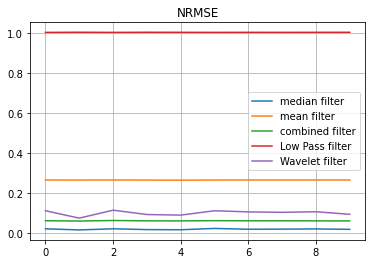

In [323]:
x = range(0,10)
plt.plot(x, b,label="median filter")
plt.plot(x, f,label="mean filter")
plt.plot(x, j,label="combined filter")
plt.plot(x, B,label="Low Pass filter")
plt.plot(x, F,label="Wavelet filter")
plt.legend()
plt.title('NRMSE')
plt.grid(True)
plt.show()

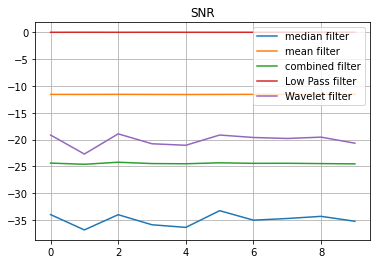

In [325]:
x = range(0,10)
plt.plot(x, c,label="median filter")
plt.plot(x, g,label="mean filter")
plt.plot(x, k,label="combined filter")
plt.plot(x, C,label="Low Pass filter")
plt.plot(x, G,label="Wavelet filter")
plt.legend()
plt.title('SNR')
plt.grid(True)
plt.show()

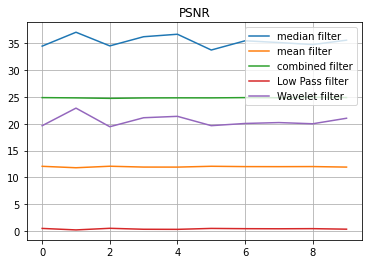

In [326]:
x = range(0,10)
plt.plot(x, d,label="median filter")
plt.plot(x, h,label="mean filter")
plt.plot(x, l,label="combined filter")
plt.plot(x, D,label="Low Pass filter")
plt.plot(x, H,label="Wavelet filter")
plt.legend()
plt.title('PSNR')
plt.grid(True)
plt.show()